In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import AutoMinorLocator

%matplotlib inline

plt.style.use('/mnt/home/tnguyen/default.mplstyle')

In [3]:
# sim_gal_table = []
# for i in range(8):
#     path = f"/mnt/ceph/users/lyung/GUREFT_Multi/run_20221122_4x/GUREFT05_{i}/galprop_156-156.dat"
#     with open(path, 'r') as dat:
#         lines   = dat.readlines()
#         header  = [
#             line.strip().split(" ")[2] for line in lines if line[0] == "#"]
#     table = pd.read_table(path, comment="#", delim_whitespace=True, names=header)
#     sim_gal_table.append(table)
# sim_gal_table = pd.concat(sim_gal_table)
# sim_halo_table = []
# for i in range(8):
#     path = f"/mnt/ceph/users/lyung/GUREFT_Multi/run_20221122_4x/GUREFT05_{i}/haloprop_156-156.dat"
#     with open(path, 'r') as dat:
#         lines   = dat.readlines()
#         header  = [
#             line.strip().split(" ")[2] for line in lines if line[0] == "#"]
#     table = pd.read_table(path, comment="#", delim_whitespace=True, names=header)
#     sim_halo_table.append(table)
# sim_halo_table = pd.concat(sim_halo_table)
# sim_table = pd.merge(sim_gal_table, sim_halo_table, on='halo_index')

In [7]:
def read_sam_table(
        datadir, min_snap, max_snap, prefix='galprop'):
    """ Read SAM data"""
    path = os.path.join(datadir, f'{prefix}_{min_snap}-{max_snap}.dat')
    print(f'read table from {path}')

    with open(path, 'r') as dat:
        lines   = dat.readlines()
        header  = [
            line.strip().split(" ")[2] for line in lines if line[0] == "#"]
    return pd.read_table(path, comment="#", delim_whitespace=True, names=header)
    
def read_sam_tables(datadir, prefix='galprop'):
    """ Read all SAM output in the directory """
    all_paths = glob.glob(os.path.join(datadir, f'{prefix}*'))
    all_tables = []
    for path in all_paths:
        with open(path, 'r') as dat:
            lines   = dat.readlines()
            header  = [
                line.strip().split(" ")[2] for line in lines if line[0] == "#"]
        table = pd.read_table(path, comment="#", delim_whitespace=True, names=header)
        all_tables.append(table)
    return pd.concat(all_tables)

def read_all_props(datadir):
    gal_table = read_sam_tables(datadir, prefix='galprop')
    halo_table = read_sam_tables(datadir, prefix='haloprop')
    return pd.merge(gal_table, halo_table, on='halo_index')

### Read data

In [12]:
data_root = "/mnt/ceph/users/tnguyen/florah/sc-sam/florah-tree/"
sim_table = read_all_props(os.path.join(data_root, 'gureft_sim/output'))
gen_table = read_all_props(os.path.join(data_root, 'gureft_gen/output'))
z = 5.89

select = (sim_table['mstar'] > 0) & (sim_table) 
sim_table = sim_table[select]
select = (gen_table['mstar'] > 0)
gen_table = gen_table[select]

### Stellar mass

In [123]:
sim_log_mstar = np.log10(sim_table['mstar'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mstar = np.log10(gen_table['mstar'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9

# Bin the data by halo mass and compute the percentiles
bins = np.arange(10, 12, 0.5)
bin_centers = (bins[1:] + bins[:-1]) / 2
num_bins = len(bins) - 1
q = [50, 16, 84]
min_num_bin = 10

sim_log_mstar_q = np.zeros((num_bins, len(q)))
gen_log_mstar_q = np.zeros((num_bins, len(q)))
for i in range(num_bins):
    select = (sim_log_mhalo > bins[i]) & (sim_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        sim_log_mstar_q[i] = np.nan
    else:
        sim_log_mstar_q[i] = np.nanpercentile(sim_log_mstar[select], q)

    select = (gen_log_mhalo > bins[i]) & (gen_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        gen_log_mstar_q[i] = np.nan
    else:
        gen_log_mstar_q[i] = np.nanpercentile(gen_log_mstar[select], q)

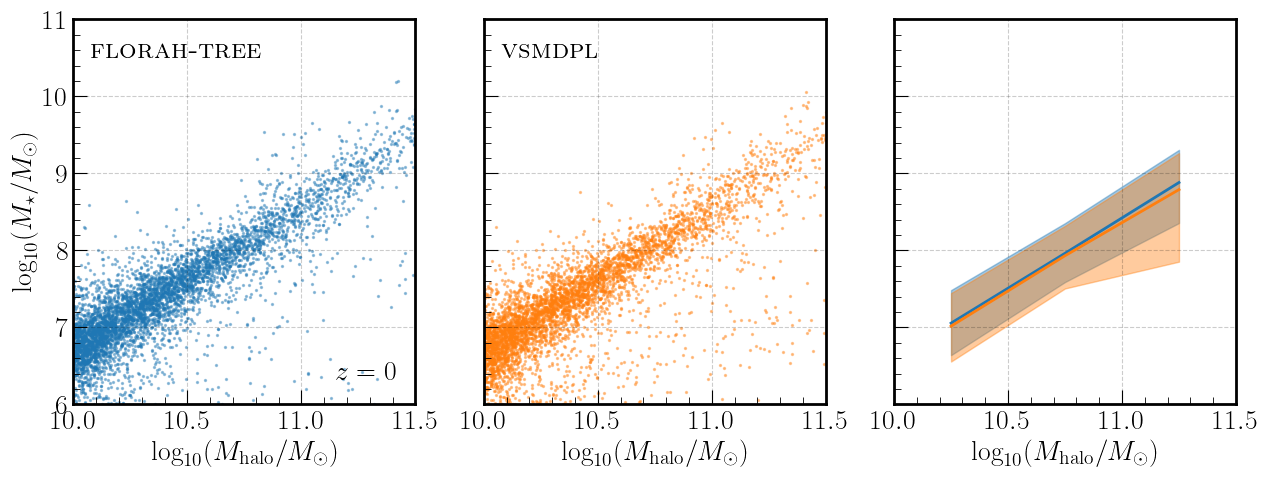

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gen_color = 'C0'
sim_color = 'C1'
xlim = (min(bins), max(bins))
ylim = (6, 11)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_mhalo, gen_log_mstar, s=2, alpha=0.4, c='C0',
    label=r'\textsc{florah-tree}')
# axes[0].plot(
    # bin_centers, gen_log_mstar_q[:, 0], color=gen_color, lw=2)
# axes[0].fill_between(
    # bin_centers, gen_log_mstar_q[:, 1], gen_log_mstar_q[:, 2], 
    # alpha=0.4, color=gen_color)

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_mhalo, sim_log_mstar, s=2, alpha=0.4, c='C1',
    label=r'\textsc{gureft-05}')
# axes[1].plot(
#     bin_centers, sim_log_mstar_q[:, 0], color=sim_color, lw=2)
# axes[1].fill_between(
#     bin_centers, sim_log_mstar_q[:, 1], sim_log_mstar_q[:, 2],
#     alpha=0.4, color=sim_color)

# plot both but only the median and 16-84 percentile
axes[2].plot(
    bin_centers, gen_log_mstar_q[:, 0], color=gen_color, lw=2,
    label=r'\textsc{florah-tree}')
axes[2].fill_between(
    bin_centers, gen_log_mstar_q[:, 1], gen_log_mstar_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    bin_centers, sim_log_mstar_q[:, 0], color=sim_color, lw=2,
    label=r'\textsc{gureft-05}')
axes[2].fill_between(
    bin_centers, sim_log_mstar_q[:, 1], sim_log_mstar_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'$\log_{10}(M_{\star}/M_{\odot})$')
for ax in axes:
    ax.set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, r'\textsc{florah-tree}',
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, r'\textsc{vsmdpl}',
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z={{{}}}$'.format(z),
    transform=axes[0].transAxes, ha='right', va='bottom')

plt.show()

### Cold gas mass

In [127]:
sim_log_mcold = np.log10(sim_table['mcold'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mcold = np.log10(gen_table['mcold'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9

# Bin the data by halo mass and compute the percentiles
bins = np.arange(8, 12, 0.5)
bin_centers = (bins[1:] + bins[:-1]) / 2
num_bins = len(bins) - 1
q = [50, 16, 84]
min_num_bin = 10

sim_log_mcold_q = np.zeros((num_bins, len(q)))
gen_log_mcold_q = np.zeros((num_bins, len(q)))
for i in range(num_bins):
    select = (sim_log_mhalo > bins[i]) & (sim_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        sim_log_mcold_q[i] = np.nan
    else:
        sim_log_mcold_q[i] = np.nanpercentile(sim_log_mcold[select], q)

    select = (gen_log_mhalo > bins[i]) & (gen_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        gen_log_mcold_q[i] = np.nan
    else:
        gen_log_mcold_q[i] = np.nanpercentile(gen_log_mcold[select], q)

/tmp/ipykernel_3766377/3506227160.py:1: RuntimeWarning: divide by zero encountered in log10
  sim_log_mcold = np.log10(sim_table['mcold'].to_numpy()) + 9
/tmp/ipykernel_3766377/3506227160.py:3: RuntimeWarning: divide by zero encountered in log10
  gen_log_mcold = np.log10(gen_table['mcold'].to_numpy()) + 9


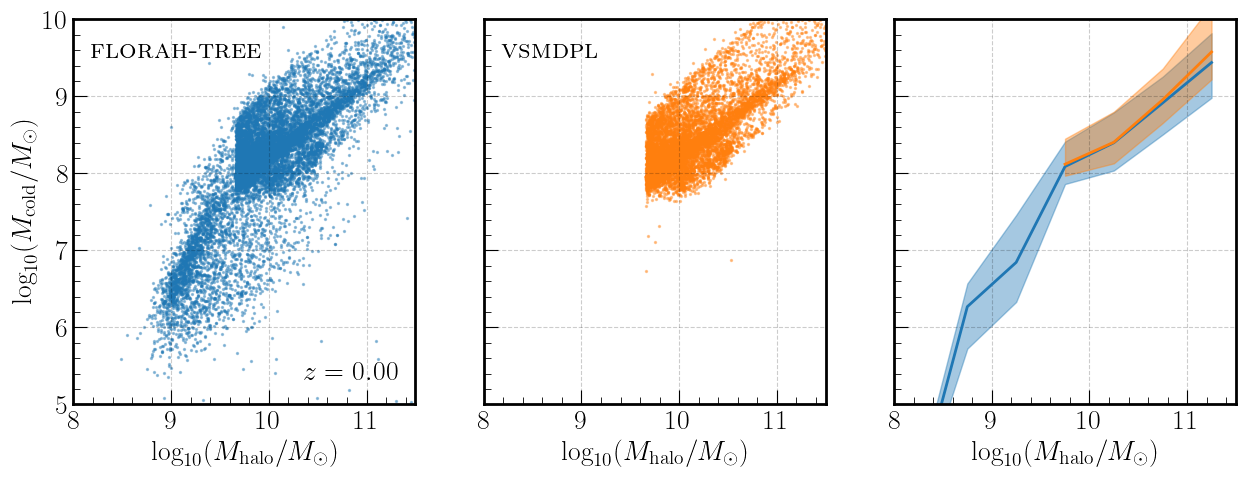

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gen_color = 'C0'
sim_color = 'C1'
xlim = (min(bins), max(bins))
ylim = (5, 10)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_mhalo, gen_log_mcold, s=2, alpha=0.4, c='C0',
    label=r'\textsc{florah-tree}')
# axes[0].plot(
#     bin_centers, gen_log_mcold_q[:, 0], color=gen_color, lw=2)
# axes[0].fill_between(
#     bin_centers, gen_log_mcold_q[:, 1], gen_log_mcold_q[:, 2], 
#     alpha=0.4, color=gen_color)

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_mhalo, sim_log_mcold, s=2, alpha=0.4, c='C1',
    label=r'\textsc{vsmdpl}')
# axes[1].plot(
#     bin_centers, sim_log_mcold_q[:, 0], color=sim_color, lw=2)
# axes[1].fill_between(
#     bin_centers, sim_log_mcold_q[:, 1], sim_log_mcold_q[:, 2],
#     alpha=0.4, color=sim_color)

# plot both but only the median and 16-84 percentile
axes[2].plot(
    bin_centers, gen_log_mcold_q[:, 0], color=gen_color, lw=2,
    label=r'\textsc{florah-tree}')
axes[2].fill_between(
    bin_centers, gen_log_mcold_q[:, 1], gen_log_mcold_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    bin_centers, sim_log_mcold_q[:, 0], color=sim_color, lw=2,
    label=r'\textsc{gureft-05}')
axes[2].fill_between(
    bin_centers, sim_log_mcold_q[:, 1], sim_log_mcold_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'$\log_{10}(M_{\rm cold}/M_{\odot})$')
axes[0].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[1].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[2].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, r'\textsc{florah-tree}',
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, r'\textsc{vsmdpl}',
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z={:.2f}$'.format(z),
    transform=axes[0].transAxes, ha='right', va='bottom')

plt.show()

### Hot gas mass

In [114]:
sim_log_mhot = np.log10(sim_table['m_hot'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mhot = np.log10(gen_table['m_hot'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9

# Bin the data by halo mass and compute the percentiles
bins = np.arange(8, 12, 0.5)
bin_centers = (bins[1:] + bins[:-1]) / 2
num_bins = len(bins) - 1
q = [50, 16, 84]
min_num_bin = 10

sim_log_mhot_q = np.zeros((num_bins, len(q)))
gen_log_mhot_q = np.zeros((num_bins, len(q)))
for i in range(num_bins):
    select = (sim_log_mhalo > bins[i]) & (sim_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        sim_log_mhot_q[i] = np.nan
    else:
        sim_log_mhot_q[i] = np.nanpercentile(sim_log_mhot[select], q)

    select = (gen_log_mhalo > bins[i]) & (gen_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        gen_log_mhot_q[i] = np.nan
    else:
        gen_log_mhot_q[i] = np.nanpercentile(gen_log_mhot[select], q)

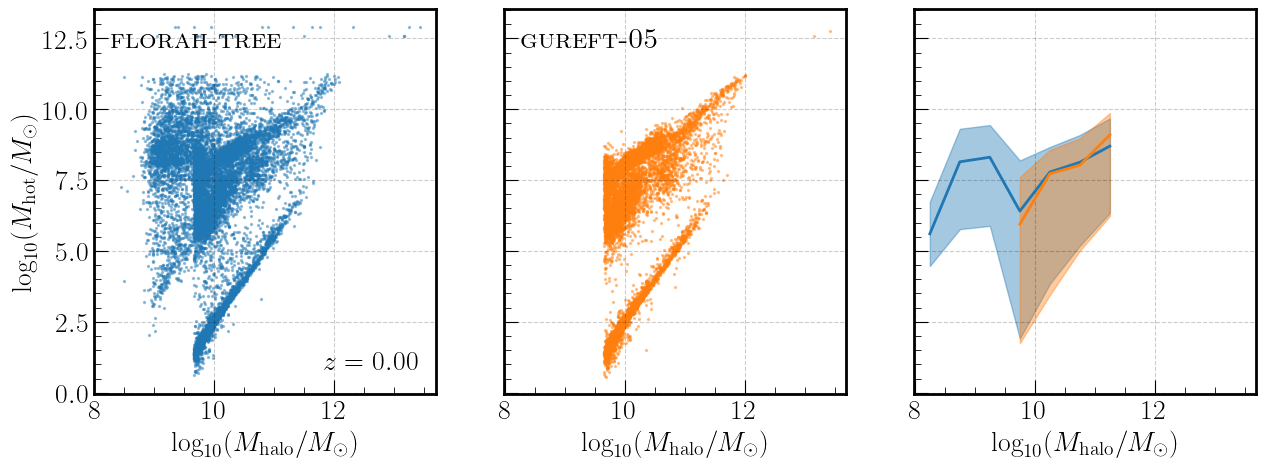

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gen_color = 'C0'
sim_color = 'C1'
xlim = (8, 9.5)
ylim = (6, 10.5)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_mhalo, gen_log_mhot, s=2, alpha=0.4, c='C0',
    label=r'\textsc{florah-tree}')
# axes[0].plot(
#     bin_centers, gen_log_mhot_q[:, 0], color=gen_color, lw=2)
# axes[0].fill_between(
#     bin_centers, gen_log_mhot_q[:, 1], gen_log_mhot_q[:, 2], 
#     alpha=0.4, color=gen_color)

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_mhalo, sim_log_mhot, s=2, alpha=0.4, c='C1',
    label=r'\textsc{gureft-05}')
# axes[1].plot(
#     bin_centers, sim_log_mhot_q[:, 0], color=sim_color, lw=2)
# axes[1].fill_between(
#     bin_centers, sim_log_mhot_q[:, 1], sim_log_mhot_q[:, 2],
#     alpha=0.4, color=sim_color)

# plot both but only the median and 16-84 percentile
axes[2].plot(
    bin_centers, gen_log_mhot_q[:, 0], color=gen_color, lw=2,
    label=r'\textsc{florah-tree}')
axes[2].fill_between(
    bin_centers, gen_log_mhot_q[:, 1], gen_log_mhot_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    bin_centers, sim_log_mhot_q[:, 0], color=sim_color, lw=2,
    label=r'\textsc{gureft-05}')
axes[2].fill_between(
    bin_centers, sim_log_mhot_q[:, 1], sim_log_mhot_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'$\log_{10}(M_{\rm hot}/M_{\odot})$')
axes[0].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[1].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[2].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
# axes[0].set_xlim(xlim)
# axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, r'\textsc{florah-tree}',
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, r'\textsc{gureft-05}',
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z={:.2f}$'.format(z),
    transform=axes[0].transAxes, ha='right', va='bottom')

plt.show()

### SFR

In [116]:
sim_log_sfr = np.log10(sim_table['sfr'].to_numpy())
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_sfr = np.log10(gen_table['sfr'].to_numpy())
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9

# Bin the data by halo mass and compute the percentiles
bins = np.arange(8, 12, 0.5)
bin_centers = (bins[1:] + bins[:-1]) / 2
num_bins = len(bins) - 1
q = [50, 16, 84]
min_num_bin = 10

sim_log_sfr_q = np.zeros((num_bins, len(q)))
gen_log_sfr_q = np.zeros((num_bins, len(q)))
for i in range(num_bins):
    select = (sim_log_mhalo > bins[i]) & (sim_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        sim_log_sfr_q[i] = np.nan
    else:
        sim_log_sfr_q[i] = np.nanpercentile(sim_log_sfr[select], q)

    select = (gen_log_mhalo > bins[i]) & (gen_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        gen_log_sfr_q[i] = np.nan
    else:
        gen_log_sfr_q[i] = np.nanpercentile(gen_log_sfr[select], q)

/tmp/ipykernel_3766377/987416825.py:3: RuntimeWarning: divide by zero encountered in log10
  gen_log_sfr = np.log10(gen_table['sfr'].to_numpy())


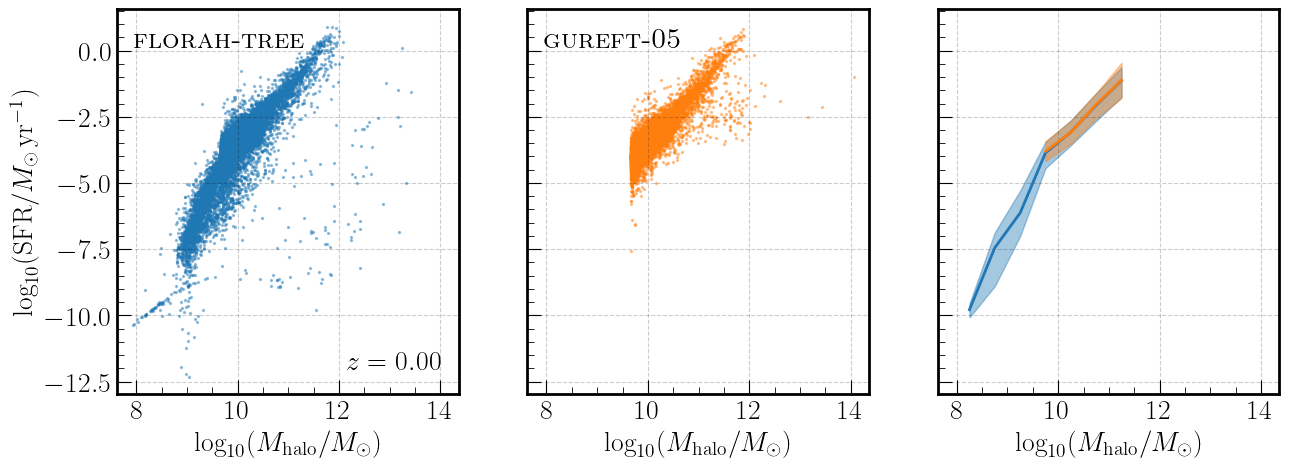

In [118]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gen_color = 'C0'
sim_color = 'C1'
xlim = (8, 9.5)
ylim = (6, 10.5)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_mhalo, gen_log_sfr, s=2, alpha=0.4, c='C0',
    label=r'\textsc{florah-tree}')
# axes[0].plot(
#     bin_centers, gen_log_sfr_q[:, 0], color=gen_color, lw=2)
# axes[0].fill_between(
#     bin_centers, gen_log_sfr_q[:, 1], gen_log_sfr_q[:, 2], 
#     alpha=0.4, color=gen_color)

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_mhalo, sim_log_sfr, s=2, alpha=0.4, c='C1',
    label=r'\textsc{gureft-05}')
# axes[1].plot(
#     bin_centers, sim_log_sfr_q[:, 0], color=sim_color, lw=2)
# axes[1].fill_between(
#     bin_centers, sim_log_sfr_q[:, 1], sim_log_sfr_q[:, 2],
#     alpha=0.4, color=sim_color)

# plot both but only the median and 16-84 percentile
axes[2].plot(
    bin_centers, gen_log_sfr_q[:, 0], color=gen_color, lw=2,
    label=r'\textsc{florah-tree}')
axes[2].fill_between(
    bin_centers, gen_log_sfr_q[:, 1], gen_log_sfr_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    bin_centers, sim_log_sfr_q[:, 0], color=sim_color, lw=2,
    label=r'\textsc{gureft-05}')
axes[2].fill_between(
    bin_centers, sim_log_sfr_q[:, 1], sim_log_sfr_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'$\log_{10}(\mathrm{SFR}/M_{\odot}\,\mathrm{yr}^{-1})$')
axes[0].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[1].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[2].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
# axes[0].set_xlim(xlim)
# axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, r'\textsc{florah-tree}',
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, r'\textsc{gureft-05}',
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z={:.2f}$'.format(z),
    transform=axes[0].transAxes, ha='right', va='bottom')

plt.show()

### BH mass

In [119]:
sim_log_mBH = np.log10(sim_table['mBH'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mBH = np.log10(gen_table['mBH'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9

# Bin the data by halo mass and compute the percentiles
bins = np.arange(8, 12, 0.5)
bin_centers = (bins[1:] + bins[:-1]) / 2
num_bins = len(bins) - 1
q = [50, 16, 84]
min_num_bin = 10

sim_log_mBH_q = np.zeros((num_bins, len(q)))
gen_log_mBH_q = np.zeros((num_bins, len(q)))
for i in range(num_bins):
    select = (sim_log_mhalo > bins[i]) & (sim_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        sim_log_mcold_q[i] = np.nan
    else:
        sim_log_mBH_q[i] = np.nanpercentile(sim_log_mBH[select], q)

    select = (gen_log_mhalo > bins[i]) & (gen_log_mhalo < bins[i+1])
    if select.sum() < min_num_bin:
        gen_log_mcold_q[i] = np.nan
    else:
        gen_log_mBH_q[i] = np.nanpercentile(gen_log_mBH[select], q)

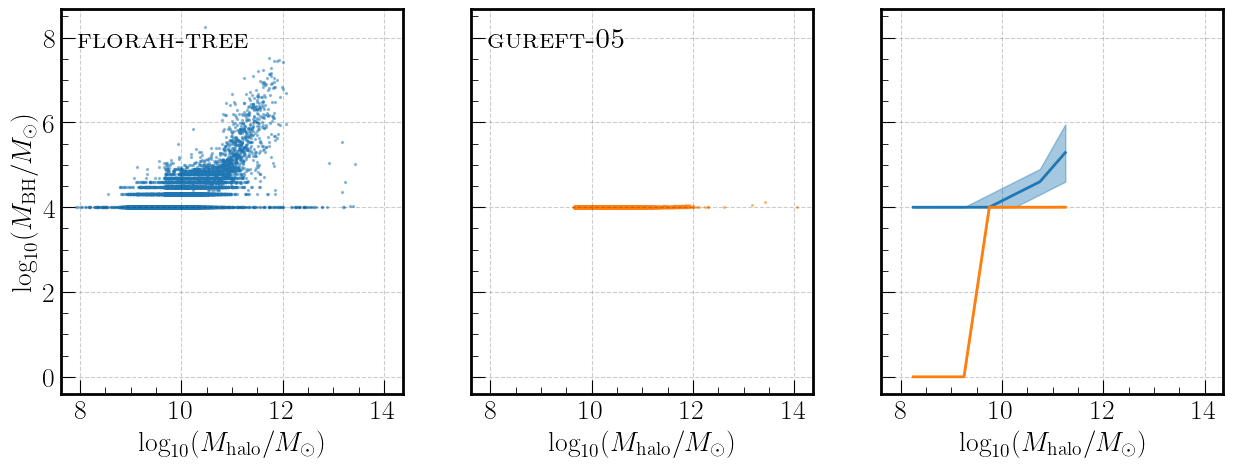

In [120]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gen_color = 'C0'
sim_color = 'C1'
xlim = (8, 9.5)
ylim = (6, 10.5)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_mhalo, gen_log_mBH, s=2, alpha=0.4, c='C0',
    label=r'\textsc{florah-tree}')
# axes[0].plot(
#     bin_centers, gen_log_mBH_q[:, 0], color=gen_color, lw=2)
# axes[0].fill_between(
#     bin_centers, gen_log_mBH_q[:, 1], gen_log_mBH_q[:, 2], 
#     alpha=0.4, color=gen_color)

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_mhalo, sim_log_mBH, s=2, alpha=0.4, c='C1',
    label=r'\textsc{gureft-05}')
# axes[1].plot(
#     bin_centers, sim_log_mBH_q[:, 0], color=sim_color, lw=2)
# axes[1].fill_between(
#     bin_centers, sim_log_mBH_q[:, 1], sim_log_mBH_q[:, 2],
#     alpha=0.4, color=sim_color)

# plot both but only the median and 16-84 percentile
axes[2].plot(
    bin_centers, gen_log_mBH_q[:, 0], color=gen_color, lw=2,
    label=r'\textsc{florah-tree}')
axes[2].fill_between(
    bin_centers, gen_log_mBH_q[:, 1], gen_log_mBH_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    bin_centers, sim_log_mBH_q[:, 0], color=sim_color, lw=2,
    label=r'\textsc{gureft-05}')
axes[2].fill_between(
    bin_centers, sim_log_mBH_q[:, 1], sim_log_mBH_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'$\log_{10}(M_{\rm BH}/M_{\odot})$')
axes[0].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[1].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
axes[2].set_xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$')
# axes[0].set_xlim(xlim)
# axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, r'\textsc{florah-tree}',
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, r'\textsc{gureft-05}',
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
# axes[0].text(
#     0.95, 0.05, r'$z={:.2f}$'.format(z),
#     transform=axes[0].transAxes, ha='right', va='bottom')

plt.show()

### Assembly bias

In [121]:
sim_log_mstar = np.log10(sim_table['mstar'].to_numpy()) + 9
sim_log_mhalo = np.log10(sim_table['mhalo'].to_numpy()) + 9
gen_log_mstar = np.log10(gen_table['mstar'].to_numpy()) + 9
gen_log_mhalo = np.log10(gen_table['mhalo'].to_numpy()) + 9
sim_log_ratio = sim_log_mstar - sim_log_mhalo
gen_log_ratio = gen_log_mstar - gen_log_mhalo
sim_log_cvir = np.log10(sim_table['c_nfw'].to_numpy())
gen_log_cvir = np.log10(gen_table['c_nfw'].to_numpy())

q = [50, 16, 84]
bins = np.linspace(0, 2, 10)  # this is concentration bin, not mass bin
bin_centers = (bins[:-1] + bins[1:]) / 2
nbins = len(bin_centers)
min_num_bin = 10
nbins_mass = 20

# calculate the median ratio in each mass bins
median = stats.binned_statistic(sim_log_mhalo, sim_log_ratio, 'median', bins=nbins_mass)
sim_shmr = sim_log_ratio.copy()
for i in range(len(median.statistic)):
    select = (median.binnumber-1==i)
    if select.sum() == 0:
        continue
    sim_shmr[select] = sim_shmr[select] - median.statistic[i]

median = stats.binned_statistic(gen_log_mhalo, gen_log_ratio, 'median', bins=nbins_mass)
gen_shmr = gen_log_ratio.copy()
for i in range(len(median.statistic)):
    select = (median.binnumber-1==i)
    if select.sum() == 0:
        continue
    gen_shmr[select] = gen_shmr[select] - median.statistic[i]

# bin everything by cvir and calculate the median and 16-84 percentile of the SHMR
sim_shmr_q = np.zeros((nbins, 3))
gen_shmr_q = np.zeros((nbins, 3))
for i in range(nbins):
    select = (sim_log_cvir >= bins[i]) & (sim_log_cvir < bins[i+1])
    if select.sum() < min_num_bin:
        sim_shmr_q[i] = np.nan
    else:
        sim_shmr_q[i] = np.nanpercentile(sim_shmr[select], q)
    select = (gen_log_cvir >= bins[i]) & (gen_log_cvir < bins[i+1])
    if select.sum() < min_num_bin:
        gen_shmr_q[i] = np.nan
    else:
        gen_shmr_q[i] = np.nanpercentile(gen_shmr[select], q)

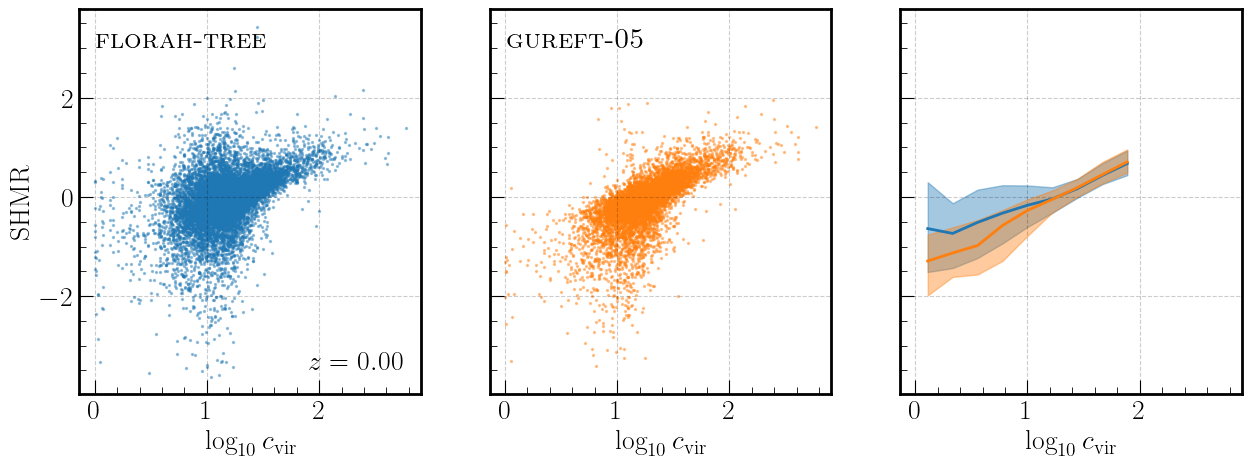

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gen_color = 'C0'
sim_color = 'C1'
xlim = (0, 1)
ylim = (-1.5, 1.5)

# plot only the generated galaxies
axes[0].scatter(
    gen_log_cvir, gen_shmr, s=2, alpha=0.4, c='C0',
    label=r'\textsc{florah-tree}')
# axes[0].plot(
#     bin_centers, gen_shmr_q[:, 0], color=gen_color, lw=2)
# axes[0].fill_between(
#     bin_centers, gen_shmr_q[:, 1], gen_shmr_q[:, 2], 
#     alpha=0.4, color=gen_color)

# plot only the simulated galaxies
axes[1].scatter(
    sim_log_cvir, sim_shmr, s=2, alpha=0.4, c='C1',
    label=r'\textsc{gureft-05}')
# axes[1].plot(
#     bin_centers, sim_shmr_q[:, 0], color=sim_color, lw=2)
# axes[1].fill_between(
#     bin_centers, sim_shmr_q[:, 1], sim_shmr_q[:, 2],
#     alpha=0.4, color=sim_color)

# plot both but only the median and 16-84 percentile
axes[2].plot(
    bin_centers, gen_shmr_q[:, 0], color=gen_color, lw=2,
    label=r'\textsc{florah-tree}')
axes[2].fill_between(
    bin_centers, gen_shmr_q[:, 1], gen_shmr_q[:, 2],
    alpha=0.4, color=gen_color)
axes[2].plot(
    bin_centers, sim_shmr_q[:, 0], color=sim_color, lw=2,
    label=r'\textsc{gureft-05}')
axes[2].fill_between(
    bin_centers, sim_shmr_q[:, 1], sim_shmr_q[:, 2],
    alpha=0.4, color=sim_color)

axes[0].set_ylabel(r'SHMR')
axes[0].set_xlabel(r'$\log_{10}c_{\rm vir}$')
axes[1].set_xlabel(r'$\log_{10}c_{\rm vir}$')
axes[2].set_xlabel(r'$\log_{10}c_{\rm vir}$')
# axes[0].set_xlim(xlim)
# axes[0].set_ylim(ylim)

# annotate the panels
axes[0].text(
    0.05, 0.95, r'\textsc{florah-tree}',
    transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(
    0.05, 0.95, r'\textsc{gureft-05}',
    transform=axes[1].transAxes, ha='left', va='top')

# redshift at the lower right
axes[0].text(
    0.95, 0.05, r'$z={:.2f}$'.format(z),
    transform=axes[0].transAxes, ha='right', va='bottom')

plt.show()